In [ ]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.models import Model

# 图像的尺寸，VGG16 224x224
img_width, img_height = 224, 224

# 数据的路径
train_data_dir = '/content/drive/MyDrive/GripDATA/Train'


# batch大小和epoch数
batch_size = 16
epochs = 50

# 加载预训练模型，不包括全连接
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

model = Sequential()
model.add(Flatten(input_shape=base_model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # 四个分类

# 预训练的底部模型和顶部模型连接
model = Model(inputs=base_model.input, outputs=model(base_model.output))

# 冻结预训练层
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# 数据增强
datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=0.2)  # 使用20%的数据作为验证集

train_generator = datagen.flow_from_directory(train_data_dir,
                                              target_size=(img_width, img_height),
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              subset='training')  # 指定这部分数据为训练集

validation_generator = datagen.flow_from_directory(train_data_dir, 
                                                   target_size=(img_width, img_height),
                                                   batch_size=batch_size,
                                                   class_mode='categorical',
                                                   subset='validation')  # 指定这部分数据为验证集


# 训练模型
model.fit(train_generator,
          steps_per_epoch=train_generator.samples // batch_size,
          epochs=epochs,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples // batch_size)


In [ ]:
model.save('my_model.h5')

In [ ]:
from keras.models import load_model

model = load_model('my_model.h5')  # 加载模型

In [ ]:
import pickle

# 保存类别映射
with open('class_indices.pkl', 'wb') as f:
    pickle.dump(train_generator.class_indices, f)


# Test


In [ ]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 28ms/step


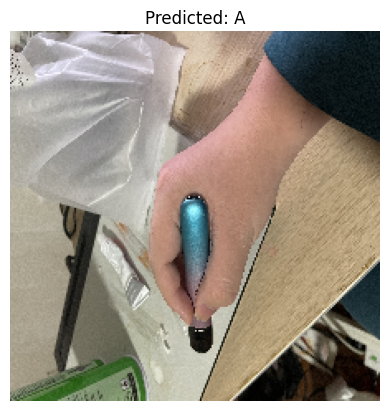

In [ ]:
from tensorflow.keras.utils import load_img,img_to_array
import numpy as np

img_path = '/content/drive/MyDrive/GripDATA/Test/微信图片_20230516193112.jpg'
img = load_img(img_path, target_size=(224, 224)) 
img_tensor = img_to_array(img)  
img_tensor = np.expand_dims(img_tensor, axis=0)  
img_tensor /= 255.  

# 加载类别映射
with open('class_indices.pkl', 'rb') as f:
    class_indices = pickle.load(f)

prediction = model.predict(img_tensor)
predicted_class_index = np.argmax(prediction)

class_names = list(class_indices.keys())
predicted_class_name = class_names[predicted_class_index]

plt.imshow(img_tensor[0])
plt.title("Predicted: " + predicted_class_name)
plt.axis('off')
plt.show()


In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import time
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import pickle


In [ ]:


# 加载模型和类别映射
model = load_model('/content/drive/MyDrive/GripDATA/my_model.h5')
with open('/content/drive/MyDrive/GripDATA/class_indices.pkl', 'rb') as f:
    class_indices = pickle.load(f)
class_names = list(class_indices.keys())

# 加载视频
video = cv2.VideoCapture('/content/1.mp4')  # replace with your video file

# 定义预处理函数
def preprocess_frame(frame):
    frame = cv2.resize(frame, (224, 224))
    frame = img_to_array(frame)
    frame = np.expand_dims(frame, axis=0)
    frame = preprocess_input(frame)
    return frame

fps = video.get(cv2.CAP_PROP_FPS)
frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
output_file = 'new.mp4'  # replace with your desired output video file
output_video = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

# 定义框的位置和大小
box_x = 50
box_y = 50
box_width = 200
box_height = 100

start = time.time()

while True:
    ret, frame = video.read()
    if not ret:
        break

    preprocessed_frame = preprocess_frame(frame)
    prediction = model.predict(preprocessed_frame)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    #print(predicted_class_name)
    if predicted_class_name == "A":  # replace with the correct class name
        color = (0, 255, 0)  # green
    else:
        color = (0, 0, 255)  # red

    # Put the result on the image within the box
    cv2.rectangle(frame, (box_x, box_y), (box_x + box_width, box_y + box_height), color, thickness=2)
    cv2.putText(frame, predicted_class_name, (box_x, box_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Write the frame with the detection result to the output video file
    output_video.write(frame)

video.release()
output_video.release()

1/1 [==============================] - 0s 144ms/step
A
1/1 [==============================] - 0s 21ms/step
A
1/1 [==============================] - 0s 21ms/step
E
1/1 [==============================] - 0s 21ms/step
A
1/1 [==============================] - 0s 21ms/step
E
1/1 [==============================] - 0s 21ms/step
E
1/1 [==============================] - 0s 21ms/step
E
1/1 [==============================] - 0s 21ms/step
E
1/1 [==============================] - 0s 21ms/step
E
1/1 [==============================] - 0s 21ms/step
E
1/1 [==============================] - 0s 21ms/step
E
1/1 [==============================] - 0s 21ms/step
E
1/1 [==============================] - 0s 20ms/step
E
1/1 [==============================] - 0s 21ms/step
E
1/1 [==============================] - 0s 21ms/step
E
1/1 [==============================] - 0s 21ms/step
A
1/1 [==============================] - 0s 21ms/step
A
1/1 [==============================] - 0s 21ms/step
A
1/1 [======================